
Selected: AAPB - GraniteShares 2x Long AAPL Daily ETF


[*********************100%***********************]  1 of 1 completed


Engineering features...
Processed data saved with 601 samples
Preparing data for model training...


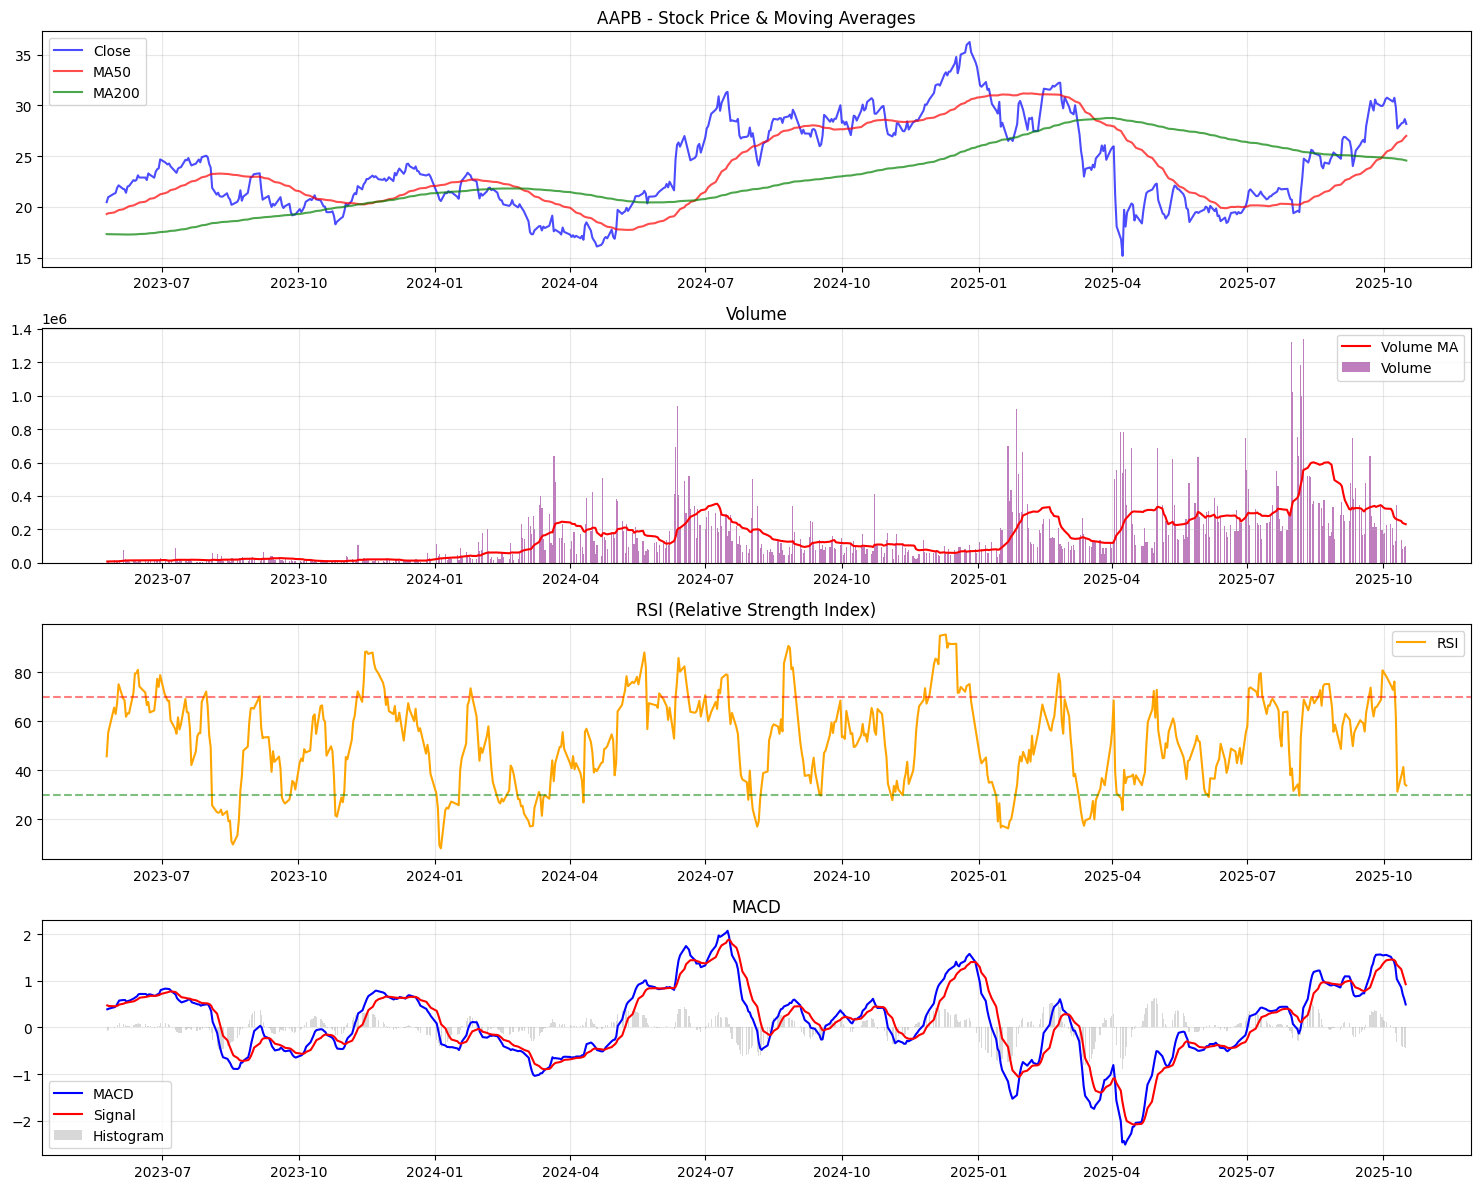


DATA PREPARATION COMPLETE FOR AAPB
✓ Raw data saved
✓ 24 features engineered
✓ Data scaled and normalized


In [5]:
#-------------------[IMPORT MODULES]-----------------------#
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

#-------------------[GET STOCK INFO]-----------------------#
try:
    stock_name = pd.read_csv('stock/nasdaq-listed-symbols.csv')
except FileNotFoundError:
    print("Error: Stock list file not found.")
    exit()

search = input("Enter the stock name or Symbol: ").strip()

matches = stock_name[
    stock_name['Company Name'].str.contains(search, case=False, na=False) |
    stock_name['Symbol'].str.contains(search, case=False, na=False)
]

if matches.empty:
    print("No matching stock found.")
    exit()

ticker = matches.iloc[0]['Symbol']
company_name = matches.iloc[0]['Company Name']
print(f"\nSelected: {ticker} - {company_name}")

#-------------------[DOWNLOAD AND PROCESS DATA]-----------------------#
print("Downloading stock data...")
try:
    data = yf.download(ticker, period='15y', auto_adjust=True)
    
    # Flatten MultiIndex columns to single level (removes ticker level)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.droplevel(1)
        
    if data.empty:
        print("Error: No data downloaded.")
        exit()
except Exception as e:
    print(f"Error: {e}")
    exit()

# Save raw data
data.to_csv(f"Training/stock_data/{ticker}_raw_data.csv")

#-------------------[FEATURE ENGINEERING]-----------------------#
print("Engineering features...")

# Moving Averages
data['MA7'] = data['Close'].rolling(7).mean()
data['MA21'] = data['Close'].rolling(21).mean()
data['MA50'] = data['Close'].rolling(50).mean()
data['MA200'] = data['Close'].rolling(200).mean()

# Exponential Moving Averages
data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()

# MACD
data['MACD'] = data['EMA12'] - data['EMA26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

# RSI (Relative Strength Index)
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
data['BB_Middle'] = data['Close'].rolling(20).mean()
data['BB_Upper'] = data['BB_Middle'] + 2 * data['Close'].rolling(20).std()
data['BB_Lower'] = data['BB_Middle'] - 2 * data['Close'].rolling(20).std()

# Volume indicators
data['Volume_MA'] = data['Volume'].rolling(20).mean()
data['Volume_Ratio'] = data['Volume'] / data['Volume_MA']

# Price momentum
data['Momentum'] = data['Close'] - data['Close'].shift(10)
data['ROC'] = ((data['Close'] - data['Close'].shift(10)) / data['Close'].shift(10)) * 100

# Volatility
data['Volatility'] = data['Close'].rolling(20).std()

# Price changes
data['Daily_Return'] = data['Close'].pct_change()
data['Price_Range'] = data['High'] - data['Low']
data['Price_Change'] = data['Close'] - data['Open']

# Target variable (Next day's closing price)
data['Target'] = data['Close'].shift(-1)

# Drop NaN values
data_clean = data.dropna()

# Save processed data
data_clean.to_csv(f"Training/stock_data/{ticker}_processed_data.csv")
print(f"Processed data saved with {len(data_clean)} samples")

#-------------------[PREPARE DATA FOR TRAINING]-----------------------#
print("Preparing data for model training...")

# Select features for training
feature_columns = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'MA7', 'MA21', 'MA50', 'MA200',
    'EMA12', 'EMA26', 'MACD', 'Signal_Line',
    'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower',
    'Volume_Ratio', 'Momentum', 'ROC', 'Volatility',
    'Daily_Return', 'Price_Range', 'Price_Change'
]

X = data_clean[feature_columns].values
y = data_clean['Target'].values



#-------------------[VISUALIZATION]-----------------------#
# Matplotlib plot with more indicators
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Price and Moving Averages
axes[0].plot(data_clean.index, data_clean['Close'], label='Close', color='blue', alpha=0.7)
axes[0].plot(data_clean.index, data_clean['MA50'], label='MA50', color='red', alpha=0.7)
axes[0].plot(data_clean.index, data_clean['MA200'], label='MA200', color='green', alpha=0.7)
axes[0].set_title(f"{ticker} - Stock Price & Moving Averages")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volume
axes[1].bar(data_clean.index, data_clean['Volume'], label='Volume', color='purple', alpha=0.5)
axes[1].plot(data_clean.index, data_clean['Volume_MA'], label='Volume MA', color='red')
axes[1].set_title("Volume")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# RSI
axes[2].plot(data_clean.index, data_clean['RSI'], label='RSI', color='orange')
axes[2].axhline(70, color='red', linestyle='--', alpha=0.5)
axes[2].axhline(30, color='green', linestyle='--', alpha=0.5)
axes[2].set_title("RSI (Relative Strength Index)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# MACD
axes[3].plot(data_clean.index, data_clean['MACD'], label='MACD', color='blue')
axes[3].plot(data_clean.index, data_clean['Signal_Line'], label='Signal', color='red')
axes[3].bar(data_clean.index, data_clean['MACD'] - data_clean['Signal_Line'], 
            label='Histogram', color='gray', alpha=0.3)
axes[3].set_title("MACD")
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interactive Plotly chart
plot_data = data_clean.reset_index()
fig = go.Figure()

fig.add_trace(go.Candlestick(
    x=plot_data['Date'],
    open=plot_data['Open'],
    high=plot_data['High'],
    low=plot_data['Low'],
    close=plot_data['Close'],
    name='Price'
))

fig.add_trace(go.Scatter(x=plot_data['Date'], y=plot_data['MA50'], 
                         name='MA50', line=dict(color='red', width=1)))
fig.add_trace(go.Scatter(x=plot_data['Date'], y=plot_data['MA200'], 
                         name='MA200', line=dict(color='green', width=1)))

fig.update_layout(
    title=f"{ticker} - {company_name} Stock Price",
    xaxis_rangeslider_visible=False,
    height=600
)
fig.show()

#-------------------[SUMMARY]-----------------------#
print(f"\n{'='*50}")
print(f"DATA PREPARATION COMPLETE FOR {ticker}")
print(f"{'='*50}")
print(f"✓ Raw data saved")
print(f"✓ {len(feature_columns)} features engineered")
print(f"✓ Data scaled and normalized")